# Formação Cientista de Dados - Data Science Academy
### Prevendo Customer Churn em Operadoras de Telecom
Projeto com Feedback 4

In [1724]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Funções Utilitarias

In [1725]:
# Carregar dados
def carrega_dados(nome_arquivo):
    return pd.read_csv(nome_arquivo)

In [1726]:
# Gerar gráficos de balanceamento de classes
def plot_balanceamento_classes(classe, titulo):
    classes, counts = np.unique(classe, return_counts=True)
    plt.bar(classes, counts)
    plt.xticks(classes)
    plt.xlabel('Classes')
    plt.ylabel('Número de amostras')
    plt.title(titulo)
    
    for i in range(len(classes)):
        plt.text(x = classes[i] - 0.05, y = counts[i] + 1, s = counts[i])
    
    plt.show()

In [1727]:
# Aplicar de label-encoding
def aplica_label_encoding(df, lista_colunas):
    le = LabelEncoder()
    for coluna in lista_colunas:
        df[coluna] = le.fit_transform(df[coluna])
    return df

In [1728]:
# Selecionando melhores variaveis para o modelo
def selecionar_melhores_variaveis(x, y, quatidade_variaveis):
    logreg = LogisticRegression(max_iter=1200)
    rfe = RFE(estimator=logreg, n_features_to_select=quatidade_variaveis)
    rfe.fit(x, y)
    return x.columns[rfe.support_]

In [1729]:
# Validando se possui/não possui informações
def validar_valores(valor):
    if valor > 0:
        return 1
    else:
        return 0

In [1730]:
# Aplicando o SMOTE para balancear as classes
def aplicar_balanceamento_classes(variavel_alvo, variaveis_preditoras):
    smote = SMOTE(random_state=42)
    return smote.fit_resample(variavel_alvo, variaveis_preditoras)

### Análise exploratória de dados

In [1731]:
# Carregando dados de Treino
df_treino = carrega_dados("datasets/train.csv")

print('dimensões:', df_treino.shape)
print('colunas:', df_treino.columns)

dimensões: (3333, 21)
colunas: Index(['Unnamed: 0', 'state', 'account_length', 'area_code',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')


In [1732]:
# Analisando dataframe
df_treino.head(5)

,Unnamed: 0,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [1733]:
# Selecionando coluna de indice
colunas_deletar = ['Unnamed: 0']

# Selecionando colunas com valores semelhantes
#colunas_deletar = colunas_deletar + ['area_code']
print('colunas que serão removidas:', colunas_deletar)

colunas que serão removidas: ['Unnamed: 0']


In [1734]:
# Analisando dados que serão excluidos
df_colunas_deletar = df_treino[colunas_deletar]
df_colunas_deletar.head(10)

,Unnamed: 0
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


In [1735]:
# Removendo colunas
df_modificado = df_treino.drop(colunas_deletar, axis=1)

In [1736]:
# Analisando dataframe após remover as colunas
print('dimensões:', df_modificado.shape)
print('tipos das variáveis:\n', df_modificado.dtypes)

df_modificado.head(5)

dimensões: (3333, 20)
tipos das variáveis:
 state                             object
account_length                     int64
area_code                         object
international_plan                object
voice_mail_plan                   object
number_vmail_messages              int64
total_day_minutes                float64
total_day_calls                    int64
total_day_charge                 float64
total_eve_minutes                float64
total_eve_calls                    int64
total_eve_charge                 float64
total_night_minutes              float64
total_night_calls                  int64
total_night_charge               float64
total_intl_minutes               float64
total_intl_calls                   int64
total_intl_charge                float64
number_customer_service_calls      int64
churn                             object
dtype: object


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
1,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
2,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
3,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
4,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [1737]:
# Verificar se precisa tratar outlier da variavel number_vmail_messages

# Analisando variáveis que podem ser modificadas por sim/não
print('valores de number_vmail_messages:', df_modificado['number_vmail_messages'].unique())
print('valores de number_customer_service_calls:', df_modificado['number_customer_service_calls'].unique())
df_modificado.sample(5)

valores de number_vmail_messages: [25 26  0 24 37 27 33 39 30 41 28 34 46 29 35 21 32 42 36 22 23 43 31 38
 40 48 18 17 45 16 20 14 19 51 15 11 12 47  8 44 49  4 10 13 50  9]
valores de number_customer_service_calls: [1 0 2 3 4 5 7 9 6 8]


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
3073,ND,84,area_code_408,no,yes,38,193.0,106,32.81,153.6,106,13.06,260.4,87,11.72,7.4,5,2.00,2,no
725,TN,57,area_code_510,no,no,0,149.3,100,25.38,200.2,110,17.02,231.7,101,10.43,11.9,3,3.21,2,no
2665,FL,85,area_code_408,yes,no,0,116.2,86,19.75,229.7,127,19.52,204.2,109,9.19,10.1,3,2.73,3,no
498,ME,75,area_code_408,yes,no,0,211.3,61,35.92,105.6,119,8.98,175.9,63,7.92,9.7,4,2.62,4,yes
2392,WY,90,area_code_510,no,no,0,125.4,158,21.32,269.1,83,22.87,238.6,103,10.74,11.0,7,2.97,1,no


In [1738]:
# Está tecnica aplicada apresentou piora na performance do modelo 
# Modificando colunas de valores numericos para binários
# df_modificado['number_vmail_messages'] = df_modificado['number_vmail_messages'].apply(validar_valores)
# df_modificado['number_customer_service_calls'] = df_modificado['number_customer_service_calls'].apply(validar_valores)
# df_modificado.sample(5)

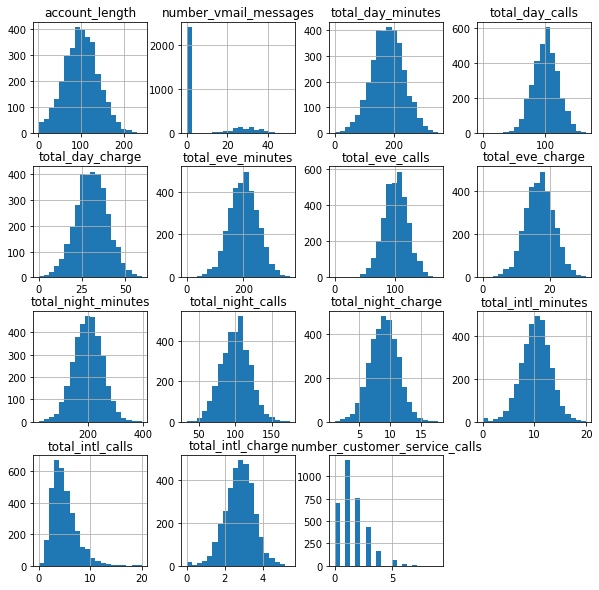

In [1739]:
# Analisando distribuição dos dados
df_modificado.hist(bins=20, figsize=(10,10))
plt.show()

### Tratamento dos dados

In [1740]:
# Selecionando variáveis categóricas
variaveis_categoricas = df_modificado.select_dtypes(include='object')

In [1741]:
# Analisando valores únicos das variáveis categóricas
for v in variaveis_categoricas:
    print('valores únicos da variável', v, ':', list(df_modificado[v].unique()))

print('\ncolunas modificadas:', list(variaveis_categoricas.columns))

valores únicos da variável state : ['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI', 'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC', 'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR', 'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC', 'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND']
valores únicos da variável area_code : ['area_code_415', 'area_code_408', 'area_code_510']
valores únicos da variável international_plan : ['no', 'yes']
valores únicos da variável voice_mail_plan : ['yes', 'no']
valores únicos da variável churn : ['no', 'yes']

colunas modificadas: ['state', 'area_code', 'international_plan', 'voice_mail_plan', 'churn']


In [1742]:
# Aplicando label-encoding nas variáveis categóricas
df_modificado = aplica_label_encoding(df_modificado, variaveis_categoricas.columns)
df_modificado.head(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,16,128,1,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,1,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,1,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,0,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,1,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [1743]:
# Analisando correlação das variáveis preditoras com a variável alvo

# Separando as variáveis preditoras e alvo
variavel_alvo = df_modificado['churn']
variaveis_preditoras = df_modificado.drop('churn', axis=1)

# Criando a matriz de correlação
matriz_correlacao_alvo = variaveis_preditoras.corrwith(variavel_alvo).sort_values(ascending=False)
matriz_correlacao_alvo = pd.DataFrame({'variavel': matriz_correlacao_alvo.index, 'correlacao': matriz_correlacao_alvo.values})

print(matriz_correlacao_alvo)

                         variavel  correlacao
0              international_plan    0.259852
1   number_customer_service_calls    0.208750
2               total_day_minutes    0.205151
3                total_day_charge    0.205151
4               total_eve_minutes    0.092796
5                total_eve_charge    0.092786
6               total_intl_charge    0.068259
7              total_intl_minutes    0.068239
8              total_night_charge    0.035496
9             total_night_minutes    0.035493
10                total_day_calls    0.018459
11                 account_length    0.016541
12                total_eve_calls    0.009233
13                          state    0.007780
14              total_night_calls    0.006141
15                      area_code    0.003256
16               total_intl_calls   -0.052844
17          number_vmail_messages   -0.089728
18                voice_mail_plan   -0.102148


In [1744]:
# Analisando correlação das variáveis

# Temos 2 possibilidade de remoção, definindo uma quantidade ou os numeros iniciais de cada correlação
#colunas_baixa_correlacao = matriz_correlacao_alvo.iloc[(matriz_correlacao_alvo['correlacao'] - 0).abs().argsort()[:4]]
colunas_baixa_correlacao = list(matriz_correlacao_alvo[matriz_correlacao_alvo["correlacao"].astype(str).str.startswith("0.00")]['variavel'])
print('colunas com baixa correlação:', colunas_baixa_correlacao)

colunas com baixa correlação: ['total_eve_calls', 'state', 'total_night_calls', 'area_code']


In [1745]:
# Removendo variáveis com baixo nível correlação
# Não é necessário remover
#df = df_modificado.drop(colunas_baixa_correlacao, axis=1)
df = df_modificado
print('\ndimensões:', df.shape)
df.head(3)


dimensões: (3333, 20)


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,16,128,1,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,1,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,1,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0


In [1746]:
# Aplicando análise de Variance inflation factor (VIF)
# Selecionando variável alvo
variaveis_preditoras = df.drop('churn', axis=1)

# Criando constante
X = sm.add_constant(variaveis_preditoras)

# Criando modelo
model = sm.OLS(df['churn'], X)

# Treinando o modelo
results = model.fit()

# Calculando o VIF para cada variável
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

#  Selecionando variáveis com alto indice VIF
colunas_alto_vif = vif[(vif["features"] != "const") & (vif["VIF Factor"] > 5)]
colunas_alto_vif = colunas_alto_vif["features"].values
colunas_alto_vif

# Removendo variáveis com alto indice VIF
print('Após testes realizados, constatei que tivemos um aumento de mais de 3% de acurácia não removendo as variáveis.')
#df = df.drop(colunas_alto_vif, axis=1)
#print('dimensões:', df.shape)
#df.head(3)

Após testes realizados, constatei que tivemos um aumento de mais de 3% de acurácia não removendo as variáveis.


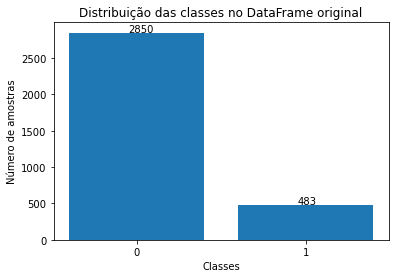

In [1747]:
# Analisando a distribuição das classes
plot_balanceamento_classes(df['churn'], 'Distribuição das classes no DataFrame original')

In [1748]:
# Separando varáveis preditoras e alvo
variavel_alvo = df.drop('churn', axis=1)
variaveis_preditoras = df['churn']

In [1749]:
# Aplicando balanceamento de classes
x_balanceado, y_balanceado = aplicar_balanceamento_classes(variavel_alvo, variaveis_preditoras)

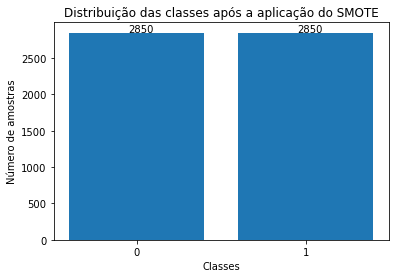

In [1750]:
# Analisando a distribuição das classes após balanceamento
plot_balanceamento_classes(y_balanceado, 'Distribuição das classes após a aplicação do SMOTE')

In [1751]:
x_balanceado.sample(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
5349,13,79,1,0,0,0,165.131042,84,28.069801,191.788256,97,16.302191,237.291276,85,10.679773,9.685989,8,2.616264,4
4645,37,147,1,1,0,0,228.443268,99,38.834872,185.994114,87,15.809874,135.033217,126,6.072690,9.782773,1,2.638740,0
5285,24,61,0,0,0,0,258.915284,107,44.017344,228.848275,117,19.453098,260.008272,77,11.703997,12.827179,2,3.460581,1
4507,43,116,0,0,0,0,270.798681,107,46.039008,235.099375,117,19.987751,243.979391,118,10.983109,9.869535,5,2.668543,1
1072,24,164,0,0,1,25,219.100000,88,37.250000,151.500000,99,12.880000,50.100000,60,2.250000,14.300000,6,3.860000,1


In [1752]:
# Selecionando variáveis numéricas
lista_colunas_nao_numericas = ['international_plan', 'voice_mail_plan']

colunas_numericas = x_balanceado.drop(lista_colunas_nao_numericas, axis=1)
print('lista_colunas_numericas:', colunas_numericas.columns)

# Criando o StandardScaler para aplicar nas variáveis
scaler = StandardScaler()

lista_colunas_numericas: Index(['state', 'account_length', 'area_code', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls'],
      dtype='object')


In [1753]:
# Analisando valores que serão normalizados.
t = x_balanceado[colunas_numericas.columns].head(5)

In [1754]:
# Aplicando padronização
x_balanceado[colunas_numericas.columns] = scaler.fit_transform(colunas_numericas)

In [1755]:
x_balanceado.head(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,-0.733724,0.695284,0.196478,0,1,1.481855,1.207020,0.465575,1.207258,-0.173696,-0.069783,-0.173503,0.886098,-0.479373,0.885313,-0.170259,-0.502398,-0.171012,-0.480499
1,0.663735,0.148144,0.196478,0,1,1.562749,-0.487908,1.133800,-0.488146,-0.211600,0.143752,-0.211056,1.088588,0.169082,1.089418,1.253414,-0.502398,1.254107,-0.480499
2,0.369533,0.929773,0.196478,0,0,-0.540501,0.851659,0.671183,0.851801,-1.693835,0.517439,-1.694385,-0.827769,0.223120,-0.826383,0.676249,0.350773,0.669808,-1.179363
3,0.663735,-0.451105,-1.261758,1,0,-0.540501,1.768721,-1.539100,1.768861,-2.876831,-0.657005,-2.877293,-0.111744,-0.587449,-0.112016,-1.478499,1.203944,-1.482121,0.218364
4,0.737285,-0.685594,0.196478,1,0,-0.540501,-0.404389,0.619781,-0.404340,-1.153208,1.158045,-1.152219,-0.320498,1.141764,-0.320760,-0.131782,-0.502398,-0.128258,0.917228


In [1756]:
# Selecionando as melhores variáveis para o modelo
melhores_variaveis = selecionar_melhores_variaveis(x_balanceado, y_balanceado, 11)

# Exibindo as variáveis selecionadas
print("Variáveis selecionadas:", melhores_variaveis)

Variáveis selecionadas: Index(['area_code', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_charge',
       'total_eve_minutes', 'total_eve_charge', 'total_intl_minutes',
       'total_intl_calls', 'number_customer_service_calls'],
      dtype='object')


In [1757]:
# Analisando dados atuais
x_balanceado.sample(10)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
3652,0.443083,-0.060291,0.196478,0,0,-0.540501,-0.302228,0.311369,-0.302330,-1.827038,-1.884833,-1.827126,0.017025,-0.587449,0.017383,-0.148967,-1.355569,-0.144322,1.616091
3224,-0.807274,0.356578,0.196478,0,0,-0.540501,0.573265,0.002958,0.573408,1.410282,-2.151752,1.410749,0.232699,-0.965714,0.231250,0.714727,-0.075812,0.712562,0.917228
5016,0.443083,-1.415115,-1.261758,0,0,-0.540501,1.622787,1.185202,1.622878,0.506425,0.570823,0.506990,0.322807,1.682143,0.322852,1.049825,-0.075812,1.055494,-1.179363
1416,0.516634,-1.936201,1.654714,0,0,-0.540501,-0.225890,1.030996,-0.226129,1.809268,-0.443470,1.809745,-0.195246,0.331195,-0.195514,-1.093723,-0.502398,-1.097339,0.917228
3172,1.766992,-1.571441,1.654714,0,0,-0.540501,0.530687,-1.744708,0.531023,0.771903,-1.404379,0.772354,0.449803,3.033090,0.449271,0.714727,0.350773,0.712562,0.917228
517,0.737285,-1.284843,-1.261758,0,0,-0.540501,0.381664,-1.693306,0.381712,-0.947730,2.012186,-0.948026,-1.646083,0.763499,-1.647440,-0.401125,-0.075812,-0.399031,0.218364
2675,0.810836,-1.076409,0.196478,0,0,-0.540501,0.268669,0.414173,0.269006,-1.647952,0.624207,-1.647444,1.865152,0.817536,1.864087,-1.824798,2.057114,-1.824150,-1.179363
2902,-1.910531,-1.050354,0.196478,0,1,0.672912,0.999044,0.259968,0.999186,-0.365209,-1.671298,-0.365960,1.197140,2.006370,1.196109,-0.170259,-0.502398,-0.171012,0.218364
523,-0.145320,-1.050354,-1.261758,0,0,-0.540501,-2.397363,0.362771,-2.397403,-1.093360,-1.404379,-1.093543,-1.030260,-0.317259,-1.030487,-0.247214,0.777358,-0.242268,0.218364
1291,1.693441,-0.894029,0.196478,0,1,1.886326,-1.011943,0.311369,-1.012181,0.536501,0.197136,0.537650,1.977879,-0.371297,1.980056,1.561235,0.350773,1.567633,-0.480499


In [1758]:
# Analisando dados somente com as variáveis selecionadas
x_balanceado = x_balanceado[melhores_variaveis]
x_balanceado.head(5)

,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_charge,total_eve_minutes,total_eve_charge,total_intl_minutes,total_intl_calls,number_customer_service_calls
0,0.196478,0,1,1.481855,1.207020,1.207258,-0.173696,-0.173503,-0.170259,-0.502398,-0.480499
1,0.196478,0,1,1.562749,-0.487908,-0.488146,-0.211600,-0.211056,1.253414,-0.502398,-0.480499
2,0.196478,0,0,-0.540501,0.851659,0.851801,-1.693835,-1.694385,0.676249,0.350773,-1.179363
3,-1.261758,1,0,-0.540501,1.768721,1.768861,-2.876831,-2.877293,-1.478499,1.203944,0.218364
4,0.196478,1,0,-0.540501,-0.404389,-0.404340,-1.153208,-1.152219,-0.131782,-0.502398,0.917228


### Modelo de Regressão Logística

In [1759]:
# Dividindo o conjunto de dados em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x_balanceado, y_balanceado, test_size=0.3, random_state=42)

In [1760]:
# Criando o modelo
model = LogisticRegression()

In [1761]:
# Trinando o modelo
model.fit(x_treino, y_treino)

LogisticRegression()

In [1762]:
# Fazendo previsões
y_pred = model.predict(x_teste)

In [1763]:
# Avaliando o modelo
accuracy = accuracy_score(y_teste, y_pred)
print("Acurácia: {:.2f}%".format(accuracy * 100))

Acurácia: 74.80%
